In [2]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
#from wordcloud import WordCloud
import pandas as pd
import numpy as np
from datetime import datetime
import os
import string
from nltk.probability import FreqDist

## Read in Covid Tweets

In [3]:
def read_txt_data(filename):
    with open(filename) as f:
        return [line.rstrip().split(",") for line in f]
    
def read_txt_label(filename):
    with open(filename) as f:
        return [line.rstrip() for line in f]


In [4]:
covid_data = read_txt_data('./covid.data.txt')
covid_label = read_txt_label('./covid_label.txt')


In [5]:
def preprocess_data(data):
    
    # date: year, month, day
    data['datetime_obj'] = datetime.strptime(data['created_at'], '%Y-%m-%dT%H:%M:%S.%fZ')
    
    return {
        'id': data['id'],
        #'year': int(data['datetime_obj'].year), 
        'month': int(data['datetime_obj'].month),
        'text': data['text'], 
        #'lang': data['lang'],
        'retweet_count': data['public_metrics']['retweet_count'],
        #'verified': int(data['user']['verified']),
        #'followers_count': data['user']['followers_count'],
        'favorite_count': data['public_metrics']['like_count'],
        'reply_count': data['public_metrics']['reply_count']
        #'location': data['user']['location']
    }

def preprocess_user(data):
    return {
        #'id': data['id'],
        #'year': int(data['datetime_obj'].year), 
        #'month': int(data['datetime_obj'].month),
        #'text': data['text'], 
        #'lang': data['lang'],
        #'retweet_count': data['user']['retweet_count'],
        'verified': int(data['user']['verified']),
        'followers_count': data['user']['followers_count'],
        #'favorite_count': data['public_metrics']['like_count'],
        'location': data['user']['location']
    }

In [6]:
# 先做15956 的covid tweet 这个是feed给分类器的 
# include text, created_at, like_count, retweet_count
# 还需要include location, follower count
# check duplicate tweet, combine 墨学 和自己的covid tweet
filename_tweets= './covid_object/{}.json' # covid_object contains user info

rumor_list = list() # store rumor tweets ids
nonrumor_list = list() # store non-rumor tweets ids
r_reply = list() # store the id of rumor replies
nonr_reply = list() # store the id of nonrumor replies
counter = 0
for data in covid_data:
    if not os.path.exists(filename_tweets.format(data[0])):
        continue
    if covid_label[counter] == '1':
        rumor_list.append(data[0])
        for d in data[1:]:
            r_reply.append(d)
    else:
        nonrumor_list.append(data[0])
        for d in data[1:]:
            nonr_reply.append(d)
    counter += 1

#rumor_df = pd.DataFrame(rumor_list)
#nonrumor_df = pd.DataFrame(nonrumor_list)

In [7]:
# store rumor and non_rumor text, date, and some public_metrics
# store rumor and non_rumor users info as well

filename = './analysis_tweet/{}.json' # analysis_tweet contains full text tweets
rumor = list()
nonrumor = list()

for data in rumor_list:
    if not os.path.exists(filename.format(data)):
        continue
    x = preprocess_data(json.load(open(filename.format(data))))
    y = preprocess_user(json.load(open(filename_tweets.format(data))))
    x.update(y)
    rumor.append(x)
    
for data in nonrumor_list:
    if not os.path.exists(filename.format(data)):
        continue
    x = preprocess_data(json.load(open(filename.format(data))))
    y = preprocess_user(json.load(open(filename_tweets.format(data))))
    x.update(y)
    nonrumor.append(x)

# Store a dataframe of rumor and nonrumor
rumor_df = pd.DataFrame(rumor)
nonrumor_df = pd.DataFrame(nonrumor)

In [8]:
rumor_df.head()
nonrumor_df.head()

,id,month,text,retweet_count,favorite_count,reply_count,verified,followers_count,location
0,1272262651100434433,6,"According to the New York Times, Warner Bros. ...",26,260,11,0,44984,Worldwide
1,1287153210990395392,7,Hurricane Hanna has made landfall in Texas.\n\...,479,583,64,1,296757,"Austin, Texas"
2,1278703879828303877,7,DISTURBING: Alabama officials say some student...,256,477,167,1,1174870,
3,1249421782630772746,4,Today I’m thinking about the families across o...,3374,23802,372,1,19661276,"Washington, DC"
4,1278159404324405248,7,Major League Soccer COVID-19 Testing Update - ...,26,52,6,1,7687,U.S. and Canada


## User Analysis

array([[<AxesSubplot:title={'center':'verified'}>]], dtype=object)

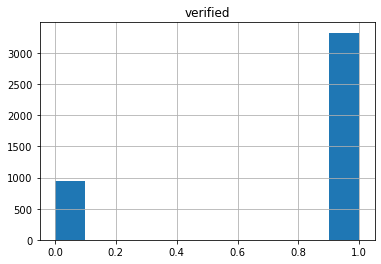

In [32]:
rumor_df.hist(column='verified')

array([[<AxesSubplot:title={'center':'verified'}>]], dtype=object)

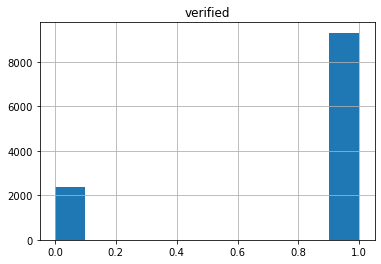

In [33]:
nonrumor_df.hist(column='verified')

In [34]:
rumor_df['followers_count'].describe()

count    4.267000e+03
mean     4.608595e+06
std      1.141370e+07
min      3.800000e+01
25%      1.367240e+05
50%      7.402150e+05
75%      2.825044e+06
max      1.317512e+08
Name: followers_count, dtype: float64

In [35]:
nonrumor_df['followers_count'].describe()

count    1.168800e+04
mean     5.004710e+06
std      1.249229e+07
min      0.000000e+00
25%      8.683900e+04
50%      5.397540e+05
75%      3.515744e+06
max      1.317522e+08
Name: followers_count, dtype: float64

## Tweet Length Analysis

In [9]:
def preprocess(text):
    new_text = []
    text = text.replace('\n', ' ') # replace newline with whitespace
    for t in text.split(" "):
        if not t.startswith('@') and not t.startswith('http') and not t.startswith("#"):
            new_text.append(t)
    return " ".join(new_text)

rumor_text = [preprocess(x) for x in rumor_df['text']] # stores rumor text without https, @, and hashtags
nonrumor_text = [preprocess(x) for x in nonrumor_df['text']] # stores nonrumor text without https, @, and hashtags

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

tt = TweetTokenizer()

# lemmatize
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

def lemmatize(word):
    lemma = lemmatizer.lemmatize(word, "v")
    if lemma == word:
        lemma = lemmatizer.lemmatize(word, "n")
    return lemma

stopwords = set(stopwords.words('english')) #note: stopwords are all in lowercase

In [10]:
# preprocess text: remove urls, tokenize each tweet, remove stopwords, punctuation, and lowercase words
# remove any remaining special characters, lemmatize text

rumor_common = list()
nonrumor_common = list()

for t in rumor_text:
    text = list()
    for w in tt.tokenize(t): # step1 tokenize
        w = str.lower(w) # step2 change to lowercase
        if any(c.encode("UTF-8").isalpha() for c in w): # step3 remove if does not contain alphabet
            w = lemmatize(w) # lemmatize
            if w not in stopwords: # step4 remove stopwords
                text.append(w)
    rumor_common.append(text)


for t in nonrumor_text:
    text = list()
    for w in tt.tokenize(t): # step1 tokenize
        w = str.lower(w) # step2 change to lowercase
        if any(c.encode("UTF-8").isalpha() for c in w): # step3 remove if does not contain alphabet
            w = lemmatize(w) # lemmatize
            if w not in stopwords: # step4 remove stopwords
                text.append(w)
    nonrumor_common.append(text)


In [14]:
# examine the full vocabulary of covid rumor tweet corpus
all_words = [word for tokens in rumor_common for word in tokens]
rumor_tweet_lengths = [len(tokens) for tokens in rumor_common]
vocab = sorted(list(set(all_words)))
print('{} words total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max tweet length is {}'.format(max(rumor_tweet_lengths)))
# change rumor_tweet_lengths list to dataframe for analysis
# rumor_tweet_lengths
rumor_lengths = pd.DataFrame(rumor_tweet_lengths)
print(rumor_lengths.describe())
print("Rumor length")

63329 words total, with a vocabulary size of 7992
Max tweet length is 37
                 0
count  4267.000000
mean     14.841575
std       7.161143
min       0.000000
25%       9.000000
50%      14.000000
75%      21.000000
max      37.000000
Rumor length


In [13]:
# examine the full vocabulary of covid nonrumor tweet corpus 
all_words = [word for tokens in nonrumor_common for word in tokens]
nonrumor_tweet_lengths = [len(tokens) for tokens in nonrumor_common]
vocab = sorted(list(set(all_words)))
print('{} words total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max tweet length is {}'.format(max(nonrumor_tweet_lengths)))
# change rumor_tweet_lengths list to dataframe for analysis 
# rumor_tweet_lengths 
nonrumor_lengths = pd.DataFrame(nonrumor_tweet_lengths)
print(nonrumor_lengths.describe())
print("Non-Rumor length")

192293 words total, with a vocabulary size of 17609
Max tweet length is 48
                  0
count  11688.000000
mean      16.452173
std        6.924357
min        0.000000
25%       11.000000
50%       17.000000
75%       22.000000
max       48.000000
Non-Rumor length


C:\Users\Win10\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


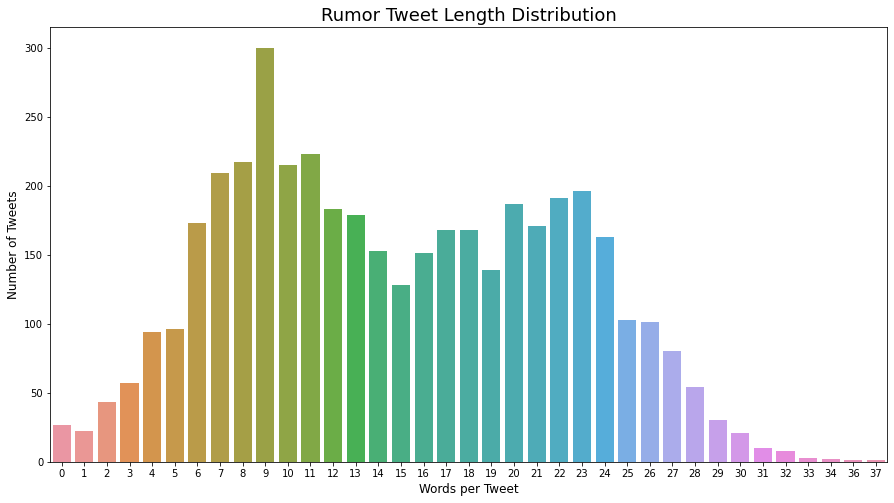

In [112]:
# bimodal distribution 
plt.figure(figsize = (15,8))
sns.countplot(rumor_tweet_lengths)
plt.title('Rumor Tweet Length Distribution', fontsize = 18)
plt.xlabel('Words per Tweet', fontsize = 12)
plt.ylabel('Number of Tweets', fontsize = 12)
plt.show()

C:\Users\Win10\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


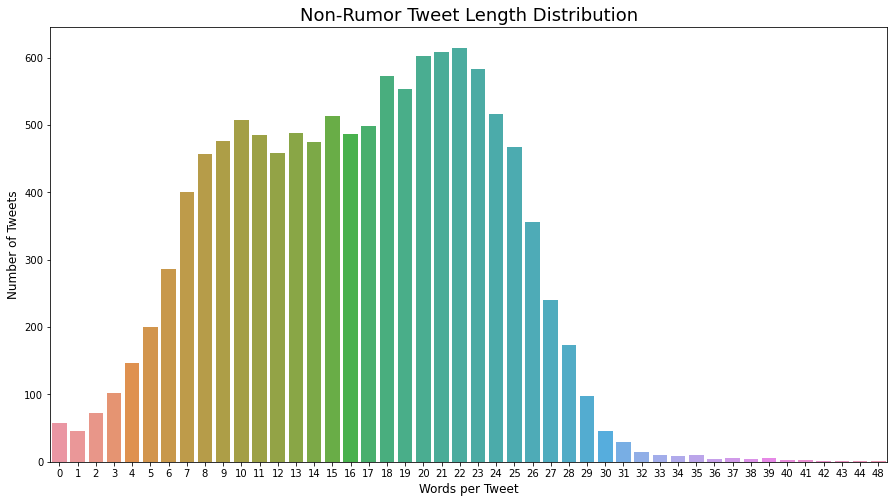

In [113]:
# Right skewed distribution 
plt.figure(figsize = (15,8))
sns.countplot(nonrumor_tweet_lengths)
plt.title('Non-Rumor Tweet Length Distribution', fontsize = 18)
plt.xlabel('Words per Tweet', fontsize = 12)
plt.ylabel('Number of Tweets', fontsize = 12)
plt.show()

## Popular Hashtags

In [16]:
def preprocess_hashtags(text):
    new_text = []
    text = text.replace('\n', ' ') # replace newline with whitespace
    for t in text.split(" "):
        if t.startswith("#"):
            new_text.append(t)
    if len(new_text) > 0:
        return " ".join(new_text)
    else:
        return

rumor_hashtags = [preprocess_hashtags(x) for x in rumor_df['text']]
nonrumor_hashtags = [preprocess_hashtags(x) for x in nonrumor_df['text']]

rumor_hashtags = [i for i in rumor_hashtags if i]
nonrumor_hashtags = [i for i in nonrumor_hashtags if i]

In [27]:

rumor_ht = list()
nonrumor_ht = list()

for t in rumor_hashtags:
    text = list()
    for w in tt.tokenize(t): # step1 tokenize
        w = str.lower(w) # step2 change to lowercase
        w = w.translate(str.maketrans('', '', string.punctuation))
        if w == ''or w == '’':
            break
        if w not in stopwords:
            if w == 'covidー19':
                w = 'covid19'
            text.append('#'+w)
    rumor_ht.append(text)
    
for t in nonrumor_hashtags:
    text = list()
    for w in tt.tokenize(t): # step1 tokenize
        w = str.lower(w) # step2 change to lowercase
        w = w.translate(str.maketrans('', '', string.punctuation))
        if w == '' or w =='’':
            break
        if w not in stopwords:
            if w == 'covidー19':
                w = 'covid19'
            if w == 'covid':
                w = 'covid19'
            text.append('#'+w)
    nonrumor_ht.append(text)

In [28]:
#iterate through each tweet, then each token in each tweet, and store in one list
flat_words = [item for sublist in rumor_ht for item in sublist]

word_freq = FreqDist(flat_words)

word_freq.most_common(20)

[('#covid19', 253),
 ('#coronavirus', 173),
 ('#china', 21),
 ('#coronaviruspandemic', 9),
 ('#maga', 9),
 ('#trump', 8),
 ('#breaking', 7),
 ('#florida', 7),
 ('#foxnews', 6),
 ('#trumppressconference', 6),
 ('#blacklivesmatter', 6),
 ('#americafirst', 5),
 ('#trumpmeltdown', 5),
 ('#trumpownseverydeath', 5),
 ('#wearethecure', 5),
 ('#crushthecurve', 5),
 ('#masstesting', 5),
 ('#inthistogetherohio', 5),
 ('#trackingandtracing', 5),
 ('#covid', 5)]

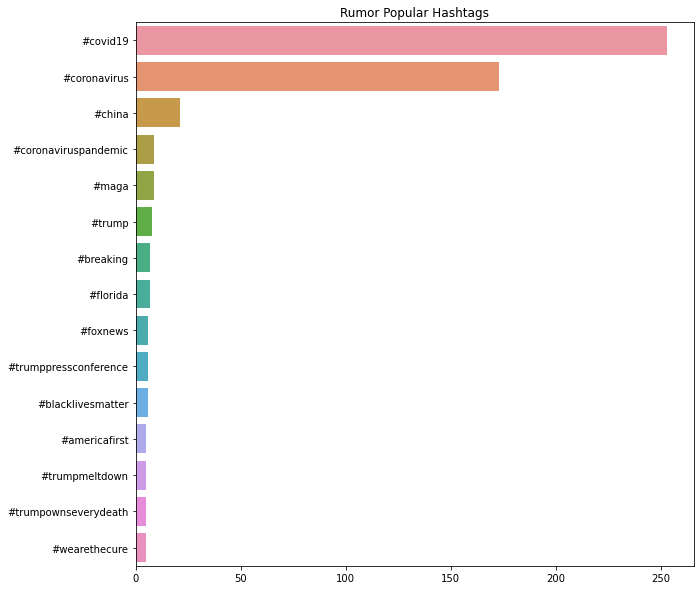

In [29]:
## Creating FreqDist for whole BoW, keeping the 20 most common tokens
all_fdist = word_freq.most_common(15)

## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(y=all_fdist.index, x=all_fdist.values, ax=ax).set(title='Rumor Popular Hashtags')
#plt.xticks(rotation=55);

In [30]:
from nltk.probability import FreqDist

#iterate through each tweet, then each token in each tweet, and store in one list
flat_words = [item for sublist in nonrumor_ht for item in sublist]

word_freq = FreqDist(flat_words)

word_freq.most_common(20)

[('#covid19', 2020),
 ('#coronavirus', 872),
 ('#breaking', 91),
 ('#stayhome', 35),
 ('#cdnpoli', 32),
 ('#coronaviruspandemic', 26),
 ('#lockdown', 24),
 ('#stayhomesavelives', 21),
 ('#covid19ph', 20),
 ('#staysafe', 19),
 ('#socialdistancing', 18),
 ('#indiafightscorona', 18),
 ('#stayathome', 17),
 ('#stayalert', 16),
 ('#auspol', 15),
 ('#china', 15),
 ('#onpoli', 14),
 ('#sarscov2', 14),
 ('#watch', 13),
 ('#hydroxychloroquine', 13)]

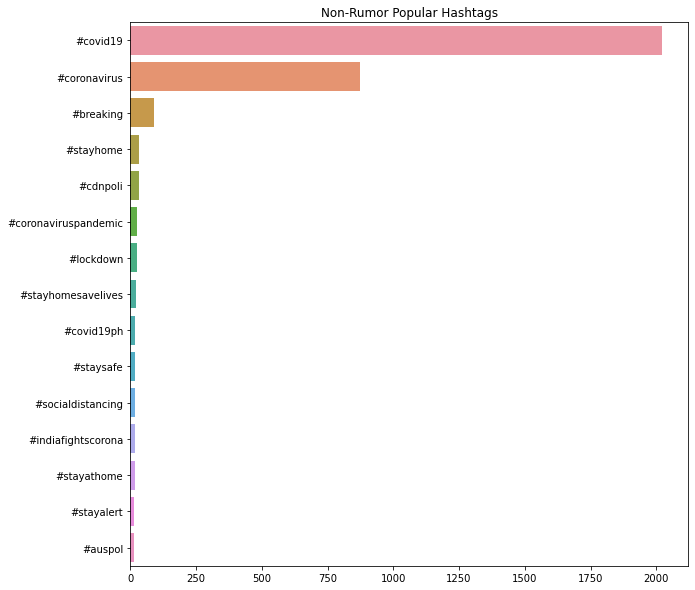

In [31]:
## Creating FreqDist for whole BoW, keeping the 20 most common tokens
all_fdist = word_freq.most_common(15)

## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(y=all_fdist.index, x=all_fdist.values, ax=ax).set(title='Non-Rumor Popular Hashtags')
#plt.xticks(rotation=55);

## Common Words

In [115]:
from nltk.probability import FreqDist

#iterate through each tweet, then each token in each tweet, and store in one list
flat_words = [item for sublist in rumor_common for item in sublist]

word_freq = FreqDist(flat_words)

word_freq.most_common(30)


[('coronavirus', 2118),
 ('trump', 1312),
 ('covid', 848),
 ('say', 735),
 ('death', 706),
 ('case', 626),
 ('u', 568),
 ('new', 542),
 ('president', 500),
 ('people', 488),
 ('american', 376),
 ('test', 366),
 ('day', 317),
 ('pandemic', 310),
 ('state', 308),
 ('china', 298),
 ('report', 294),
 ('go', 286),
 ('die', 266),
 ('one', 254),
 ('get', 248),
 ('week', 233),
 ('million', 222),
 ('time', 209),
 ('call', 198),
 ('florida', 182),
 ('virus', 181),
 ('like', 175),
 ('know', 174),
 ('make', 174)]

In [ ]:
#retrieve word and count from FreqDist tuples

most_common_count = [x[1] for x in word_freq.most_common(30)]
most_common_word = [x[0] for x in word_freq.most_common(30)]

#create dictionary mapping of word count
top_30_dictionary = dict(zip(most_common_word, most_common_count))
#Create Word Cloud of top 30 words
wordcloud = WordCloud(colormap = 'Accent', background_color = 'black')\
.generate_from_frequencies(top_30_dictionary)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('top_30_cloud.png')

print("Rumor WordCloud")
plt.show()

In [116]:
#iterate through each tweet, then each token in each tweet, and store in one list
flat_words = [item for sublist in nonrumor_common for item in sublist]

word_freq = FreqDist(flat_words)

word_freq.most_common(30)



[('coronavirus', 4274),
 ('covid', 3260),
 ('test', 1773),
 ('say', 1496),
 ('case', 1471),
 ('new', 1361),
 ('people', 1233),
 ('u', 1065),
 ('pandemic', 1013),
 ('state', 864),
 ('health', 844),
 ('day', 812),
 ('death', 808),
 ('trump', 775),
 ('get', 768),
 ('positive', 748),
 ('go', 725),
 ('one', 698),
 ('today', 655),
 ('report', 634),
 ('take', 633),
 ('time', 602),
 ('need', 598),
 ('president', 590),
 ('country', 588),
 ('die', 587),
 ('work', 583),
 ('mask', 570),
 ('make', 546),
 ('break', 546)]

In [ ]:
#retrieve word and count from FreqDist tuples

most_common_count = [x[1] for x in word_freq.most_common(30)]
most_common_word = [x[0] for x in word_freq.most_common(30)]

#create dictionary mapping of word count
top_30_dictionary = dict(zip(most_common_word, most_common_count))

#Create Word Cloud of top 30 words
wordcloud = WordCloud(colormap = 'Accent', background_color = 'black')\
.generate_from_frequencies(top_30_dictionary)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('top_30_cloud.png')
print("Non-Rumor WordCloud")
plt.show()